In [6]:
import numpy as np
import webapi_access as api
from datetime import datetime as dt
import matplotlib.pyplot as p

# sample time test example plot
loc = '//share.ipp-hgw.mpg.de/documents/pih/Documents/git/LaTeX/THESIS/content/figures/chapter1/'

import os
os.chdir('//share.ipp-hgw.mpg.de/documents/pih/Documents/git/QSB_Bolometry/libprad')

# timing evaluation for lab tests with new, newer and old version
# set samples times and frequency
sST = [x * 1.e-3 for x in [0.8, 1.0, 1.6, 3.2, 6.4]]
sSF = [1. / x for x in sST]

# actual sample times
aST_w = [x * 1.e-3 for x in [.7584, 0.9504, 1.5552, 3.1488, 6.336]]  # wRTF
aST_wo = [x * 1.e-3 for x in [0.7584, 0.9504, 1.5552, 3.1488, 6.336]]  # woRTF

# actual sample frequencies
aSF_master = [x * 1.e3 for x in [1.25502, 1.0016, 0.62751, 0.312813, 0.156406]]  # master
aST_master = [1. / x for x in aSF_master]  # master

aSF_w = [1. / x for x in aST_w]  # wRTF
aSF_wo = [1. / x for x in aST_wo]  # woRTF

# laser
laserF = 10.  # Hz
laserT = 1 / laserF

# library start times
lib_master0 = np.array([  # master
    [1611739579000000000, 0.8e-3, 50],  # 0.8 ms, 50s
    [1611740225000000000, 1.0e-3, 50],  # 1.0 ms, 50s
    [1611740414000000000, 1.6e-3, 50],  # 1.6 ms, 50s
    [1611740533000000000, 3.2e-3, 50],  # 3.2 ms, 50s
    [1611740661000000000, 6.4e-3, 50],   # 6.4 ms, 50s
])

lib_master = np.array([  # master
    [1611739579000000000, 0.8e-3, 50],  # 0.8 ms, 50s
    [1611741849000000000, 1.0e-3, 62.5],  # 1.0 ms, 62.5s
    [1611742069000000000, 1.6e-3, 100],  # 1.6 ms, 100s
    [1611742231000000000, 3.2e-3, 200],  # 3.2 ms, 200s
    [1611740897000000000, 6.4e-3, 400]  # 6.4 ms, 400s
])

lib_wRTF = np.array([  # wRTF
    [1611743194000000000, 0.8e-3, 50],  # 0.8 ms, 50s
    [1611743361000000000, 1.0e-3, 62.5],  # 1.0 ms, 62.5 s
    [1611744467000000000, 1.6e-3, 100],  # 1.6 ms, 100s
    [1611744638000000000, 3.2e-3, 200],  # 3.2 ms, 200s
    [1611745853000000000, 6.4e-3, 400]  # 6.4 ms, 400s  
])

lib_woRTF = np.array([  # woRTF
    [1611746590000000000, 0.8e-3, 50],  # 0.8 ms, 50s
    [1611746700000000000, 1.0e-3, 62.5],  # 1.0 ms, 62.5 s
    [1611746833000000000, 1.6e-3, 100],  # 1.6 ms, 100s
    [1611747289000000000, 3.2e-3, 200],  # 3.2 ms, 200s
    [1611747588000000000, 6.4e-3, 400],  # 6.4 ms, 400s
    [1611853356000000000, 0.8e-3, 50],  # 0.8 ms, 50s wo load
    [1611853194000000000, 0.8e-3, 50],  # 0.8 ms, 50s w load
    [1611852896000000000, 1.0e-3, 50],  # 1.0 ms, 50s wo load
    [1611853589000000000, 1.0e-3, 50]  # 1.0 ms, 50s w load
])

In [52]:
""" loading and finding experiments """
label, meas_set = 'lib_woRTF', lib_woRTF

data = []
for i, entry in enumerate(meas_set):
    T0 = dt.utcfromtimestamp(  # datetime
        int(entry[0] * 1.e-9))  # from ns float to int
    T1 = dt.utcfromtimestamp(
        int(entry[0] * 1.e-9 + entry[2] + 1))
    
    F, test = api.load_non_XP_ids(  # get entries in XP
        start_search=int(entry[0]),
        stop_search=int(entry[0] + entry[2] * 1.e9))

    dat = api.download_single(  # download datas
        data_req=api.download_link(), program_info=None,
        start_POSIX=F[0, 0], stop_POSIX=F[1, 0])
    data.append([  # time and data
        np.array(dat['dimensions']),
        np.array(dat['values'])])

# marke true arrays
data_woRTF = np.array(data)

In [53]:
""" loading and finding experiments """
data = data_woRTF

""" correction and diff """
corrected, derivates = [], []  # flat and derivates
for i in range(np.shape(meas_set)[0]):
    # time in seconds  
    t = (data[i, 0] - data[i, 0][0]) / 1.e9
    N = int(10.e-3 / meas_set[i, 1])

    c = np.zeros((np.shape(data[i, 1])))
    for ch in range(128):  # corrected
        c[ch] = np.convolve(
            data[i, 1][ch] - np.min(data[i, 1][ch]),
            np.ones((N,)) / N, mode='same')
    corrected.append([t, c / np.max(np.abs(c))])
    
    # first and second derivative
    d, d2 = np.zeros((np.shape(data[i, 1]))), \
        np.zeros((np.shape(data[i, 1])))
    for ch in range(128):  # dU/dt, unsmoothed
        d[ch] = np.gradient(c[ch], t[1] - t[0])
        d2[ch] = np.gradient(d[ch], t[1] - t[0])
    derivates.append([t, d / np.max(np.abs(d)), d2 / np.max(np.abs(d2))])

# marke true arrays
corrected, derivates = np.array(corrected), np.array(derivates)

""" search points and measure """
results, errors, period_timing = [], [], []  # results and errors
for i in range(np.shape(meas_set)[0]):    
    # prepare results etc
    results.append([])
    errors.append([])
    period_timing.append([])

    N = int(10.e-3 / meas_set[i, 1])
    # get where the sign of the first derivative changes
    ind = np.where(np.diff(np.sign(derivates[i, 1][0])))[0]

    j = 0  # stop before second to last is reached (diff) 
    while j < np.shape(ind)[0] - 2:
        I1, I2 = ind[j], ind[j + 1]

        # if unrealistic, assume spike, jitter, lost samples
        if (I2 - I1) <= ((laserT / 2.) / meas_set[i, 1]) * (1 / 3):
            # sample distance is less than 66% of the
            # expected amount when half laser period / base sample time
            errors[i].append(np.array([I1, I2]))

        else:
            T = derivates[i, 0][I2] - derivates[i, 0][I1]
            st = meas_set[i, 1] * 0.05 / T
            
            # index, index, point in time, meas time, set time
            # meas sample time, set sample time
            results[i].append(np.array([
                I1, I2, derivates[i, 0][I1], T, laserT / 2.,
                st,  meas_set[i, 1]]))

        if (I2 - I1) > N:
            period_timing[i].append(np.array([
                I1, I2 - I1]))
        j += 1  # advance

# marke true arrays
results, errors, period_timing = \
    np.array(results), np.array(errors), \
    np.array(period_timing)

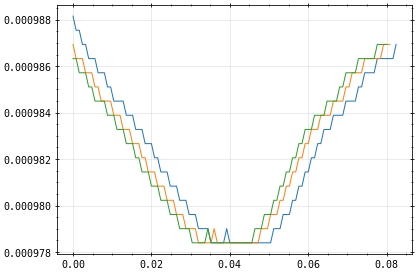

In [119]:
d = data[0]
fig, ax = p.subplots()

#for i, e in enumerate(errors[0]):
for i in range(89, 92): # i = 9
    e = errors[0][i]

    # print(e[0], e[1])
    ax.plot(
        (d[0][e[0]-50:e[1]+50] - d[0][e[0]-50]) * 1.e-9,
        d[1][0, e[0]-50:e[1]+50])

# if i == 10:
# break

In [64]:
""" plotting """
for i in range(1):  # 6, np.shape(meas_set)[0]):  # all sample times
    fig, ax = p.subplots()  # np.shape(meas_set)[0], 1)  # sharey=True)
    fig.set_size_inches(4., 2.2)  # np.shape(meas_set)[0])

    ax.plot(  # sample time
        [x[0] for x in period_timing[i][1:]],
        [x[1] for x in period_timing[i][1:]],
        c='k', marker='+', markersize=1.5,
        ls='None', lw=0.3, alpha=0.75)
    
    dT = 1.
    target = 0.05 / meas_set[i, 1]
    ax.fill_between(
        [0.0, max([x[0] for x in period_timing[i][1:]])],
        [target - dT, target - dT],
        [target + dT, target + dT],
        color='r', alpha=0.3)
    ax.plot(  # target line
        [0.0, max([x[0] for x in period_timing[i][1:]])],
        [target, target],  # number of samples
        color='r', ls=':', label='half period')
    
    # ax.legend()
    ax.set_xlim(0.0, max([x[0] for x in period_timing[i][1:]]))

    ax.set_xlabel('sample number [#]')
    ax.set_ylabel('samples [#]')
    ax.set_title(str(meas_set[i, 1] * 1.e3) + 'ms')

    fig.tight_layout()
    fig.savefig(
        label + '_branch_nS_' +
        str(meas_set[i, 1] * 1.e3)
        + 'ms.pdf', dpi=169.)
    p.close('all')

In [68]:
""" plotting """
for i in range(5):  # 6, np.shape(meas_set)[0]):  # all sample times
    fig, ax = p.subplots()  # np.shape(meas_set)[0], 1)  # sharey=True)
    fig.set_size_inches(4., 2.2)  #  * np.shape(meas_set)[0])

    ax.plot(  # sample time
        [x[2] for x in results[i]],
        [x[5] * 1.e3 for x in results[i]],
        c='k', marker='+', markersize=1.5,
        ls='None', lw=0.3, alpha=0.75)
    
    dT = meas_set[i, 1] / ((laserT / 2.) / meas_set[i, 1])
    dTmin, dTmax = (meas_set[i, 1] - dT) * 1.e3, \
        (lib_woRTF[i, 1] + dT) * 1.e3
    ax.fill_between(
        [0.0, derivates[i, 0].max()],
        [dTmin, dTmin], [dTmax, dTmax],
        color='r', alpha=0.3)
    ax.plot(  # target line
        [0.0, derivates[i, 0].max()],
        [meas_set[i, 1] * 1.e3, meas_set[i, 1] * 1.e3],
        color='r', ls=':', label='set sample time')

    # ax.legend(
    #     # bbox_to_anchor=(.45, .4),
    #     ncol=1, fancybox=True, shadow=False,
    #     handletextpad=0.3, labelspacing=0.5, handlelength=1.)
    dS = np.std([x[5] * 1.e3 for x in results[i]])
    ax.set_ylim(
       lib_woRTF[i, 1] * 1.e3 - 2. * dS,
       lib_woRTF[i, 1] * 1.e3 + 2. * dS)
    ax.set_xlim(0.0, derivates[i, 0].max())

    ax.set_xlabel('acquisition time [s]')
    ax.set_ylabel('sample time [ms]')
    ax.set_title(str(meas_set[i, 1] * 1.e3) + 'ms')

    fig.tight_layout()
    fig.savefig(
        label + '_branch_sT_' +
        str(meas_set[i, 1] * 1.e3) + 'ms.pdf',
        dpi=169.)
    p.close('all')